# Anomaly Detection with the PyOD (Python Outlier Detector) 

### Set up the exercise

In [1]:
# Install and import the necessary modules
!pip install pyod

     |████████████████████████████████| 113 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 306 kB 3.4 MB/s eta 0:00:01
  Using cached matplotlib-3.4.3-cp38-cp38-macosx_10_9_x86_64.whl (7.2 MB)
  Using cached numba-0.54.1-cp38-cp38-macosx_10_14_x86_64.whl (2.3 MB)
  Using cached scipy-1.7.1-cp38-cp38-macosx_10_9_x86_64.whl (32.6 MB)
  Using cached scikit_learn-1.0.1-cp38-cp38-macosx_10_13_x86_64.whl (7.9 MB)
  Using cached statsmodels-0.13.0-cp38-cp38-macosx_10_15_x86_64.whl (9.5 MB)
  Using cached llvmlite-0.37.0-cp38-cp38-macosx_10_9_x86_64.whl (19.1 MB)
  Using cached numpy-1.20.3-cp38-cp38-macosx_10_9_x86_64.whl (16.0 MB)
  Using cached threadpoolctl-3.0.0-py3-none-any.whl (14 kB)
  Using cached kiwisolver-1.3.2-cp38-cp38-macosx_10_9_x86_64.whl (61 kB)
  Using cached Pillow-8.4.0-cp38-cp38-macosx_10_10_x86_64.whl (3.0 MB)
  Using cached patsy-0.5.2-py2.py3-none-any.whl (233 kB)
     |████████████████████████████████| 11.4 MB 9.2 MB/s eta 0:00:01
Using legacy 'setup.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data

/Users/nshpak/code/fourthbrain/venv/lib/python3.8/site-packages/pyod/utils/data.py:186: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.9.0. Please use behaviour="new", which makes the returned datasets in the order of X_train, X_test, y_train, y_test.
  warn('behaviour="old" is deprecated and will be removed '


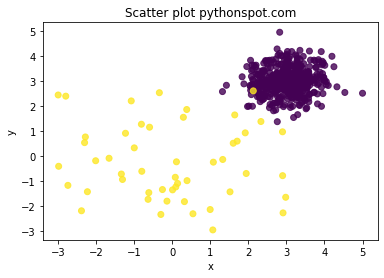

In [3]:
# Set the parameters and generate the data
contamination = 0.1 # fraction of outliers
n_train = 500       # number of training points
n_test  = 500       # number of testing points
n_features = 2      # number of features
random_state = 18   # random state for reproducibility
X_train, y_train, X_test, y_test = generate_data(n_train=n_train, 
                                                 n_test=n_test, 
                                                 n_features=n_features, 
                                                 contamination=contamination,
                                                 random_state=random_state)

# Make the 2d numpy array a pandas dataframe for each manipulation 
X_train_pd = pd.DataFrame(X_train)
    
# Plot
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [4]:
print(f'For {n_train} training observations and {100*contamination} % contamination, we expect {int(n_train*contamination)} outliers')
print(f'For {n_test} test observations and {100*contamination} % contamination, we expect {int(n_test*contamination)} outliers')

For 500 training observations and 10.0 % contamination, we expect 50 outliers
For 500 test observations and 10.0 % contamination, we expect 50 outliers


Let's see if we can find these outliers consistently

PyOD's models allow the user to see intermediate scores which indicate the model's confidence in a given point being an outlier. Moreover, the user can then use the trained model to generate these outlier scores on test data.

Let's see this in action with PyOD's k-NN model, which by default has `n_neighbors=5` for k

In [5]:
# train kNN detector
from pyod.models.knn import KNN
from pyod.utils.utility import standardizer

def get_knn_scores_and_predictions(X_train, X_test, n_neighbors=5):
    ### START CODE HERE ###
    # Initialize the model
    clf = KNN(n_neighbors=n_neighbors)
    # Train the model
    clf.fit(X_train)
    # Get the training data's outlier/decision scores with the decision_scores_ attribute
    y_train_scores = clf.decision_scores_
    # Generate the anomaly scores for the test data using the decision_function() method 
    y_test_scores = clf.decision_function(X_test)
    # Convert the outlier scores to 2D column arrays, then standardize them so they have 
    # a mean of 0 and standard deviation of 1
    y_train_scores_norm, y_test_scores_norm = standardizer(y_train_scores.reshape(-1, 1)), standardizer(y_test_scores.reshape(-1, 1))
    # Apply the model to the test data to get predictions
    y_test_pred = y_test_scores > clf.threshold_
    ### END CODE HERE ###
    return y_train_scores_norm, y_test_scores_norm, y_test_pred.astype(int)

# Call the function with the default KNN
y_train_scores_norm, y_test_scores_norm, y_test_pred = get_knn_scores_and_predictions(X_train, X_test)

### Count how many test data points are "normal" (inliers) and outliers

In [15]:
# We have a binary classification problem ("normal" points labeled 0 and outliers labeled 1)
# Let's see how many points are predicted to belong to each class
unique, counts = np.unique(y_test_pred, return_counts=True)
for label, count in dict(zip(unique, counts)).items():
    print(f'{count} points in the test data are predicted to belong to class {label}')

455 points in the test data are predicted to belong to class 0
45 points in the test data are predicted to belong to class 1


### Visualize the distribution of the standardized test data outlier scores

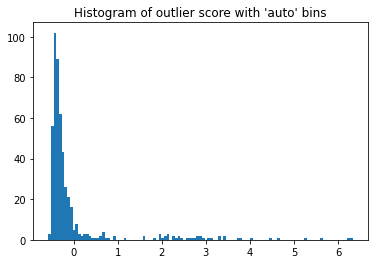

In [16]:
plt.hist(y_test_scores_norm, bins='auto') 
plt.title("Histogram of outlier score with 'auto' bins")
plt.show()

It seems reasonable to assume that points with outlier scores below a certain threshold are assigned to Class 0 (the normal, inlier class), and those with scores above are assigned to Class 1 (the anomalous, outlier class). 

From glancing at the plot above, 0 appears to be a good threshold score. 

In [6]:
def clustering(X_test, y_test_scores_norm, threshold=0):
    ### START CODE HERE ###
    # Create a new DataFrame from the test features
    df_test = pd.DataFrame(X_test)
    # Make a new column containing each point's outlier score
    df_test['score'] = y_test_scores_norm
    # Assign each point to a cluster based on the side of the threshold
    # on which its outlier score falls
    df_test['cluster'] = df_test['score'].apply(lambda score: int(score > threshold))
    # Print the number of points assigned to each cluster
    print('Class counts:')
    print(df_test['cluster'].value_counts())
    print('Mean value of each feature within each cluster:')
    print('Mean Outlier', df_test['score'][df_test['cluster'] == 1].mean())
    print('Mean Inliner', df_test['score'][df_test['cluster'] == 0].mean())
    ### END CODE HERE ###
    return df_test

# Call the function
df_test = clustering(X_test, y_test_scores_norm, threshold=0)

Class counts:
0    420
1     80
Name: cluster, dtype: int64
Mean value of each feature within each cluster:
Mean Outlier 1.753376171716237
Mean Inliner -0.3339764136602355


### Inspect visually how our model performed

In [7]:
def get_plots(X_test, y_test, y_test_pred, df_test):
    plt.tight_layout()

    plt.subplots(1, 3, figsize = (18, 6))

    plt.subplot(1,3,1)
    plt.scatter(X_test[:,0], X_test[:,1], c=y_test, alpha=0.8)
    plt.title('Inliers vs. Outliers: Ground Truth')
    plt.xlabel('x')
    plt.ylabel('y')

    plt.subplot(1,3,2)
    plt.scatter(X_test[:,0], X_test[:,1], c=y_test_pred, alpha=0.8)
    plt.title('Inliers vs. Outliers: Automatic Predictions')
    plt.xlabel('x')
    plt.ylabel('y')

    plt.subplot(1,3,3)
    plt.scatter(df_test[0], df_test[1], c=df_test['cluster'], alpha=0.8)
    plt.title('Inliers vs. Outliers: Predictions by Threshold')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
    # Dummy return
    return None

<Figure size 432x288 with 0 Axes>

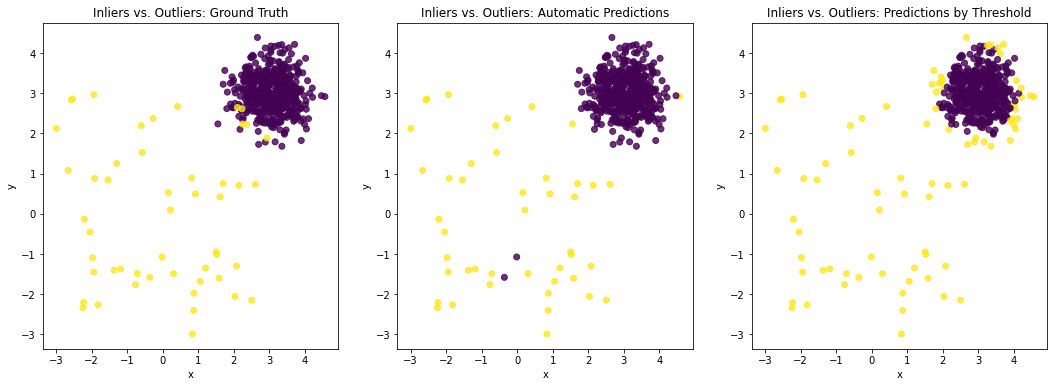

In [8]:
get_plots(X_test, y_test, y_test_pred, df_test)

Combine the previous visualizations into a single function.

In [9]:
def knn_anomaly_detection(X_train, y_train, X_test, y_test, n_neighbors=5, threshold=0): 
    ### START CODE HERE ###
    # Get scores and predictions
    y_train_scores_norm, y_test_scores_norm, y_test_pred = get_knn_scores_and_predictions(X_train, X_test, n_neighbors=n_neighbors)
    # Count the number of points in the test data predicted to belong to each class
    unique, counts = np.unique(y_test_pred, return_counts=True)
    for label, count in dict(zip(unique, counts)).items():
        print(f'{count} points in the test data are predicted to belong to class {label}')
    # Visualize the distribution of outlier scores in the test data
    plt.hist(y_test_scores_norm, bins='auto') 
    plt.title("Histogram of outlier score with 'auto' bins")
    plt.show()
    # Clustering by threshold
    df_test = clustering(X_test, y_test_scores_norm, threshold=threshold)
    get_plots(X_test, y_test, y_test_pred, df_test)

463 points in the test data are predicted to belong to class 0
37 points in the test data are predicted to belong to class 1


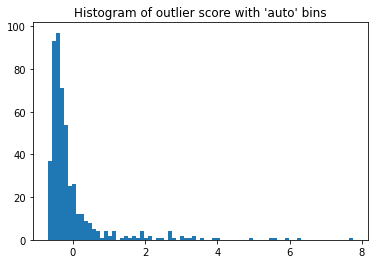

Class counts:
0    381
1    119
Name: cluster, dtype: int64
Mean value of each feature within each cluster:
Mean Outlier 1.1780725620383017
Mean Inliner -0.36795442226393127


<Figure size 432x288 with 0 Axes>

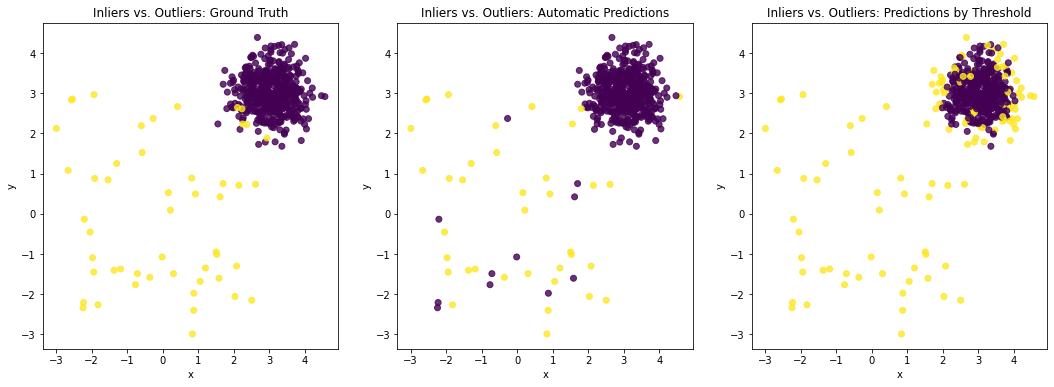

In [10]:
knn_anomaly_detection(X_train, y_train, X_test, y_test, n_neighbors=1, threshold=0)

455 points in the test data are predicted to belong to class 0
45 points in the test data are predicted to belong to class 1


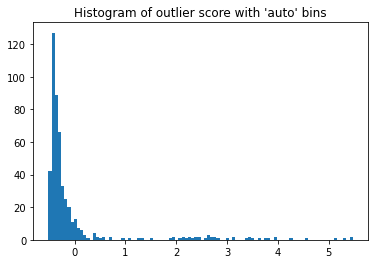

Class counts:
0    418
1     82
Name: cluster, dtype: int64
Mean value of each feature within each cluster:
Mean Outlier 1.7221825603453287
Mean Inliner -0.3378444257136768


<Figure size 432x288 with 0 Axes>

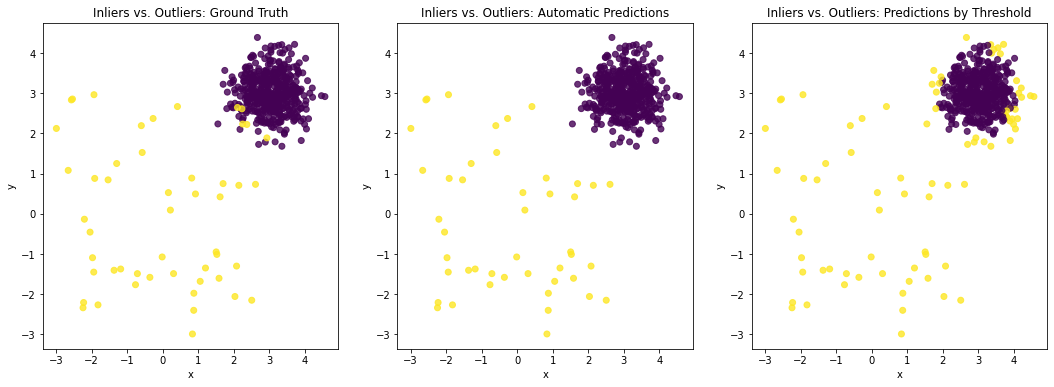

In [11]:
knn_anomaly_detection(X_train, y_train, X_test, y_test, n_neighbors=9, threshold=0)

### Get PCA scores and predictions

In [14]:
from pyod.models.pca import PCA

def get_pca_scores_and_predictions(X_train, X_test, n_components=2):
    ### START CODE HERE ###
    # Initialize the model
    clf = PCA(n_components=n_components)
    # Train the model
    clf.fit(X_train)
    # Get the training data's outlier/decision scores with the decision_scores_ attribute
    y_train_scores = clf.decision_scores_
    # Generate the anomaly score using the decision_function() method
    y_test_scores = clf.decision_function(X_test)
    # Convert the outlier scores to 2D column arrays, then standardize them
    y_train_scores_norm, y_test_scores_norm = standardizer(y_train_scores.reshape(-1, 1)), standardizer(y_train_scores.reshape(-1, 1))
    # Apply the model to the test data to get predictions
    y_test_pred = clf.predict(X_test)
    return y_train_scores_norm, y_test_scores_norm, y_test_pred

In [15]:
y_train_scores_norm, y_test_scores_norm, y_test_pred = get_pca_scores_and_predictions(X_train, X_test)

In [16]:
def pca_anomaly_detection(X_train, y_train, X_test, y_test, n_components=2, threshold=0):
    ### START CODE HERE ###
    # Get scores and predictions
    y_train_scores_norm, y_test_scores_norm, y_test_pred = get_pca_scores_and_predictions(X_train, X_test, n_components=n_components)
    # Count the number of points in the test data predicted to belong to each class
    unique, counts = np.unique(y_test_pred, return_counts=True)
    for label, count in dict(zip(unique, counts)).items():
        print(f'{count} points in the test data are predicted to belong to class {label}')
    # Visualize the distribution of outlier scores in the test data
    plt.hist(y_test_scores_norm, bins='auto') 
    plt.title("Histogram of outlier score with 'auto' bins")
    plt.show()
    # Clustering by threshold
    df_test = clustering(X_test, y_test_scores_norm, threshold=0)
    get_plots(X_test, y_test, y_test_pred, df_test)

447 points in the test data are predicted to belong to class 0
53 points in the test data are predicted to belong to class 1


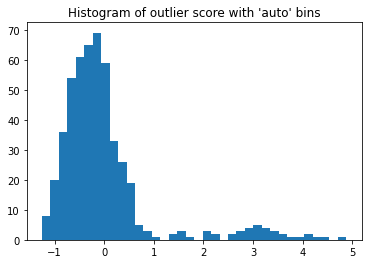

Class counts:
0    339
1    161
Name: cluster, dtype: int64
Mean value of each feature within each cluster:
Mean Outlier 0.9607787866565356
Mean Inliner -0.45629906976903317


<Figure size 432x288 with 0 Axes>

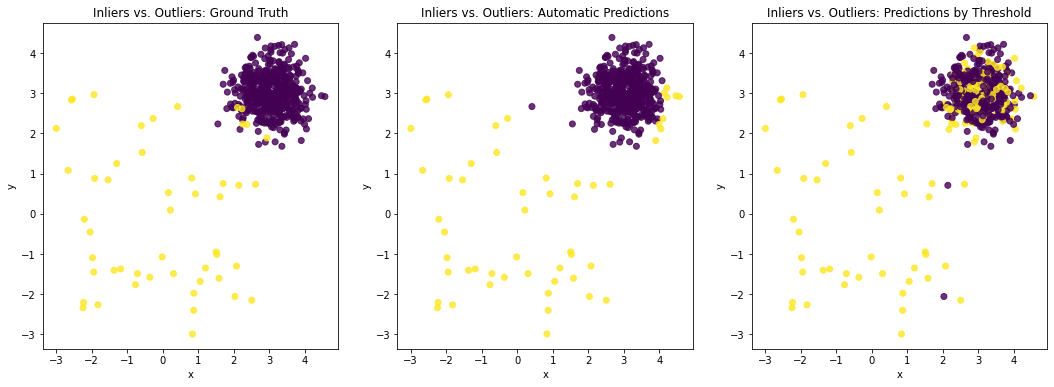

In [17]:
pca_anomaly_detection(X_train, y_train, X_test, y_test, n_components=2, threshold=0)

447 points in the test data are predicted to belong to class 0
53 points in the test data are predicted to belong to class 1


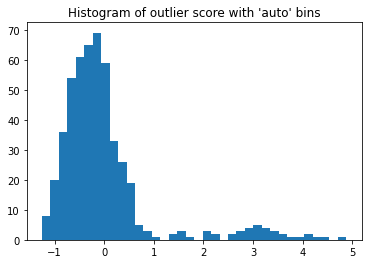

Class counts:
0    339
1    161
Name: cluster, dtype: int64
Mean value of each feature within each cluster:
Mean Outlier 0.9607787866565356
Mean Inliner -0.45629906976903317


<Figure size 432x288 with 0 Axes>

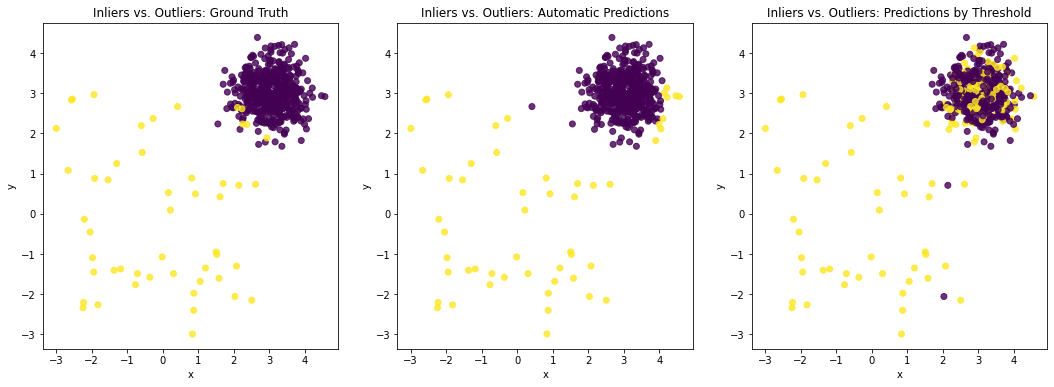

In [18]:
pca_anomaly_detection(X_train, y_train, X_test, y_test, n_components=2, threshold=1)